# Multi-Class Text Classification - Balanced Dataset

Inspired by Susan Li's tutorial: https://towardsdatascience.com/multi-class-text-classification-model-comparison-and-selection-5eb066197568

In this notebook, we are using a large dataset of Stack Overflow questions and tags. It's available at this Cloud Storage URL: https://storage.googleapis.com/tensorflow-workshop-examples/stack-overflow-data.csv.

The goal of this notebook is to predict the 'tags' according to the content of a 'post'. In other words:
- Input: post
- Output: tags

## Exploring the dataset

In [1]:
import pandas as pd
df = pd.read_csv('./data/stack-overflow-data.csv')

# We remove the rows where the 'tags' is not filled in
df = df[pd.notnull(df['tags'])]

print('Dataframe shape:', df.shape)
df.head()

Dataframe shape: (40000, 2)


,post,tags
0,what is causing this behavior in our c# datet...,c#
1,have dynamic html load as if it was in an ifra...,asp.net
2,how to convert a float value in to min:sec i ...,objective-c
3,.net framework 4 redistributable just wonderi...,.net
4,trying to calculate and print the mean and its...,python


Let's see an overview of the disribution of the dataset according to the tags.

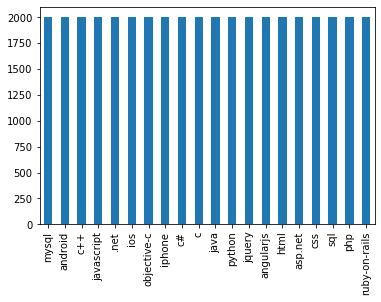

In [3]:
import matplotlib.pyplot as plt

my_tags = ['java','html','asp.net','c#','ruby-on-rails','jquery','mysql','php','ios','javascript','python','c','css','android','iphone','sql','objective-c','c++','angularjs','.net']

plt.figure()
df.tags.value_counts().plot(kind='bar')
plt.show()

The classes are balanced.

Let's see an overview of the posts that we can find in the dataset.

In [4]:
df.iloc[0, 0]

'what is causing this behavior  in our c# datetime type  <pre><code>[test] public void sadness() {    var datetime = datetime.utcnow;    assert.that(datetime  is.equalto(datetime.parse(datetime.tostring()))); } </code></pre>   failed :   <pre><code> expected: 2011-10-31 06:12:44.000  but was:  2011-10-31 06:12:44.350 </code></pre>   i wish to know what is happening behind the scenes in tostring() etc to cause this behavior.    edit after seeing jon s answer :   <pre><code>[test] public void newsadness() {     var datetime = datetime.utcnow;     assert.that(datetime  is.equalto(datetime.parse(datetime.tostring( o )))); } </code></pre>   result :   <pre><code>expected: 2011-10-31 12:03:04.161 but was:  2011-10-31 06:33:04.161 </code></pre>   same result with capital and small  o  . i m reading up the docs  but still unclear.'

In [5]:
df.iloc[1000,0]

'collect information from two tables in foreaches  i have the image product id in one database table and the image source in another table. these are all put into an order. there can be more than one image in a single order. i am trying to send each picture to pwinty.    so for each image i need to make this:    <pre><code>$photo = $pwinty-&gt;addphoto($order   $size    $source    $qty    shrinktofit ); // i have not got to the size and qty variable yet  // because of that i have this instead $photo = $pwinty-&gt;addphoto($order   4x6    $source    1    shrinktofit ); </code></pre>   right now  because they are in multiple tables i have the following code: (which is not returning the photo array above at all.    <pre><code>// get the customers pictures for this order  foreach ($db-&gt;query( select * from order_products where order_id=$order_id ) as $row) $picture_info[] = $row;  if (count($picture_info) &gt; 0):     foreach ($picture_info as $row):          $product_id = $row[ product

The post's content are not really readable. We need to clean them up.

## Text Pre-processing

There are many Text Pre-processing methods, in our case we are going to:
- decode HTML
- change text to lower case
- remove punctuation
- remove bad characters
- remove "stop words" (most common words in a language &#8594; no information provided)

In [6]:
import nltk
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup

# nltk.download('stopwords')

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        return: initial string pre-processed
    """
    text = BeautifulSoup(text).decode()
    text = text.lower()
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    text = BAD_SYMBOLS_RE.sub('', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text

df['post'] = df['post'].apply(clean_text)

Let's see the precedent posts after the pre-processing.

In [7]:
df.iloc[0, 0]

'causing behavior c# datetime type precode test public void sadness var datetime datetimeutcnow assertthat datetime isequalto datetimeparse datetimetostring code pre failed precode expected 20111031 061244000 20111031 061244350 code pre wish know happening behind scenes tostring etc cause behavior edit seeing jon answer precode test public void newsadness var datetime datetimeutcnow assertthat datetime isequalto datetimeparse datetimetostring code pre result precodeexpected 20111031 120304161 20111031 063304161 code pre result capital small reading docs still unclear'

In [8]:
df.iloc[1000,0]

'collect information two tables foreaches image product id one database table image source another table put order one image single order trying send picture pwinty image need make precodephoto pwintygt addphoto order size source qty shrinktofit got size qty variable yet instead photo pwintygt addphoto order 4x6 source 1 shrinktofit code pre right multiple tables following code returning photo array precode get customers pictures order foreach dbgt query select order_products order_idorder_id row picture_info row count picture_info gt 0 foreach picture_info row product_id row product_id echo product_id foreach dbgt query select products product_idproduct_id row picture_source row foreach picture_source row source row product_image echo source add photos photo pwintygt addphoto order 4x6 source 1 shrinktofit endforeach endforeach endif code pre returning precode14138646283376c471632817da60f95964cb2d57dc46png array id gt 7776 address1 gt 2002 e blain address2 gt postalorzipcode gt 68460 

Much more readable!

## Multi-Class Classifier

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix

X = df.post
y = df.tags
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Naive Bayes Classifier for Multinomial Models

In [10]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
%time nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)

print('accuracy', accuracy_score(y_pred, y_test), '\n')
print(classification_report(y_test, y_pred,target_names=my_tags))

Wall time: 3.86 s
accuracy 0.753875 

               precision    recall  f1-score   support

         java       0.60      0.67      0.63       377
         html       0.93      0.84      0.88       437
      asp.net       0.94      0.92      0.93       433
           c#       0.71      0.74      0.72       387
ruby-on-rails       0.77      0.87      0.82       421
       jquery       0.73      0.54      0.62       387
        mysql       0.82      0.75      0.78       411
          php       0.71      0.89      0.79       401
          ios       0.57      0.65      0.61       378
   javascript       0.61      0.68      0.65       397
       python       0.72      0.57      0.64       412
            c       0.74      0.80      0.77       377
          css       0.78      0.58      0.67       391
      android       0.72      0.80      0.76       402
       iphone       0.69      0.83      0.75       414
          sql       0.71      0.67      0.69       400
  objective-c       0.83  

### Linear Support Vector Machine

In [11]:
from sklearn.svm import LinearSVC

lsvc = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LinearSVC()),
               ])
%time lsvc.fit(X_train, y_train)

y_pred = lsvc.predict(X_test)

print('accuracy', accuracy_score(y_pred, y_test), '\n')
print(classification_report(y_test, y_pred,target_names=my_tags))

Wall time: 7.45 s
accuracy 0.811875 

               precision    recall  f1-score   support

         java       0.73      0.69      0.71       377
         html       0.94      0.92      0.93       437
      asp.net       0.98      0.95      0.97       433
           c#       0.80      0.75      0.78       387
ruby-on-rails       0.82      0.87      0.85       421
       jquery       0.68      0.65      0.66       387
        mysql       0.81      0.76      0.78       411
          php       0.80      0.88      0.84       401
          ios       0.70      0.71      0.70       378
   javascript       0.71      0.66      0.68       397
       python       0.69      0.73      0.71       412
            c       0.84      0.84      0.84       377
          css       0.79      0.79      0.79       391
      android       0.86      0.86      0.86       402
       iphone       0.86      0.80      0.83       414
          sql       0.72      0.67      0.69       400
  objective-c       0.84  

### Logistic Regression

In [12]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(solver='newton-cg', multi_class='multinomial')),
               ])
%time logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

print('accuracy', accuracy_score(y_pred, y_test), '\n')
print(classification_report(y_test, y_pred,target_names=my_tags))

Wall time: 2min 28s
accuracy 0.8065 

               precision    recall  f1-score   support

         java       0.69      0.69      0.69       377
         html       0.94      0.87      0.90       437
      asp.net       0.99      0.92      0.95       433
           c#       0.80      0.72      0.76       387
ruby-on-rails       0.83      0.87      0.85       421
       jquery       0.59      0.66      0.63       387
        mysql       0.81      0.76      0.78       411
          php       0.81      0.88      0.85       401
          ios       0.68      0.75      0.71       378
   javascript       0.70      0.69      0.70       397
       python       0.73      0.73      0.73       412
            c       0.83      0.81      0.82       377
          css       0.78      0.78      0.78       391
      android       0.87      0.84      0.85       402
       iphone       0.86      0.81      0.84       414
          sql       0.74      0.70      0.72       400
  objective-c       0.87  

### Neural Network 

In [13]:
from IPython.display import clear_output

import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing import text
from tensorflow.keras import utils

from sklearn.preprocessing import LabelEncoder

tf.__version__

'2.0.0'

Prepare the data for training

In [14]:
train_size = int(len(df) * .8)
train_posts = df['post'][:train_size]
train_tags = df['tags'][:train_size]

test_posts = df['post'][train_size:]
test_tags = df['tags'][train_size:]

print('Train size:', train_size)
print('Test size:', len(df)-train_size)

Train size: 32000
Test size: 8000


In [15]:
max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)
tokenize.fit_on_texts(train_posts)

x_train = tokenize.texts_to_matrix(train_posts)
x_test = tokenize.texts_to_matrix(test_posts)

In [16]:
encoder = LabelEncoder()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)

In [17]:
num_classes = np.max(y_train) + 1

y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (32000, 1000)
x_test shape: (8000, 1000)
y_train shape: (32000, 20)
y_test shape: (8000, 20)


In [18]:
batch_size = 32
epochs = 3

Build the model

In [19]:
%%time

model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, input_shape=(max_words,)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes),
    tf.keras.layers.Activation('softmax')
])

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(x_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1
                   )

Train on 28800 samples, validate on 3200 samples
Epoch 1/3
28800/28800 [==============================] - 5s 177us/sample - loss: 2.2548 - accuracy: 0.4561 - val_loss: 1.4543 - val_accuracy: 0.7353
Epoch 2/3
28800/28800 [==============================] - 4s 145us/sample - loss: 1.1825 - accuracy: 0.7319 - val_loss: 0.9134 - val_accuracy: 0.7831
Epoch 3/3
28800/28800 [==============================] - 4s 147us/sample - loss: 0.8634 - accuracy: 0.7707 - val_loss: 0.7583 - val_accuracy: 0.7947
Wall time: 13.7 s


In [20]:
score = model.evaluate(x_test, 
                       y_test,
                       batch_size=batch_size,
                       verbose=1
                      )

clear_output(wait=True)
print('Test accuracy:', score[1])

Test accuracy: 0.800875


In [21]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

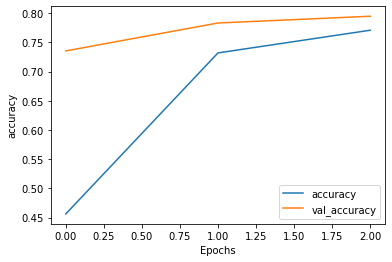

In [22]:
plot_graphs(history, 'accuracy')

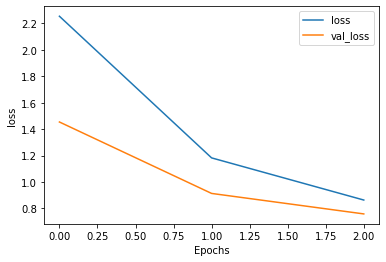

In [23]:
plot_graphs(history, 'loss')

## Conclusion

A summary of previous results obtained:

|            Methods            | Accuracy |   Time   |
|:-----------------------------:|:--------:|:--------:|
| Naive Bayes                   | 0.753875 | 3.86 s   |
| Linear Support Vector Machine | 0.811875 | 7.45 s   |
| Logistic Regression           | 0.8065   | 2min 28s |
| Neural Network                | 0.800875 | 13.7 s   |

The method with the highest accuracy was **Linear Support Vector Machine**. In addition, this method is the second fastest method for the training phase. In my opinion, this is the optimal method to use in our classification problem.